# Stress Test Yaw-Rate
This is brief example of using AdaStress to adaptively stress test an external simulation. This is done by sending and receiving data over TCP between AdaStress and the main vehicle simulation.

In [73]:

using Pkg
Pkg.activate(".")

include("transceive_data.jl")

  Activating new project at `~/Repos/simple-vehicle-sim/ST_yaw_rate`


transceive_send_reset_cmd (generic function with 1 method)

In [74]:
using AdaStress
import AdaStress.BlackBox
using Plots

# Simulation

In [75]:
using Distributions
using Random

const PORT_STRESS = 9900
const IP_ADDR = "localhost"

"localhost"

In [76]:
# AdaStress interface setup
Base.@kwdef mutable struct simple_vehicle <: AdaStress.BlackBox
	count::Int64 = 0
	count_max::Int64 = 10
	psi_dot::Float64 = 0.0 # the yaw-rate of the vehicle
	psi_dot_fail::Float64 = 10.0 # radians per second
	dist::Normal = Normal(0.0, 0.25)
	log::Vector{Float64} = []
end


function initialize!(sim::simple_vehicle)
	# In this example yaw rate is the only consideration and resetting the 
	# vehicle's entire state in the simple vehicle program is not implemented 
	# here. When resetting the __entire__ vehicle state, a function will need to 
	# be implemented that sends a "vehicle-state-reset-message" to the 
	# c-simulation that message not implemented yet
	sim.count = 0
	sim.psi_dot = 0.0
	sim.log = [sim.psi_dot]
	transceive_send_reset_cmd()
end

function update!(sim::simple_vehicle)
	sim.psi_dot = transceive_read_bytes_from_simulation()
    stress_value = Float32(rand(sim.dist))
	t = typeof(stress_value)
	transceive_send_float(stress_value)
    push!(sim.log, sim.psi_dot)
	
    sim.count = sim.count + 1
    return logpdf(sim.dist, stress_value) - logpdf(sim.dist, 0.0)
end

update! (generic function with 1 method)

In [77]:
AdaStress.reset!(sim::simple_vehicle) = initialize!(sim)
AdaStress.step!(sim::simple_vehicle) = update!(sim)
AdaStress.isterminal(sim::simple_vehicle) = sim.count >= sim.count_max
AdaStress.isevent(sim::simple_vehicle) = abs(sim.psi_dot) >= sim.psi_dot_fail
AdaStress.distance(sim::simple_vehicle) = max(sim.psi_dot_fail - sim.psi_dot, 0.0)

In [78]:
println("In a separate terminal, run")
println("`./bin/main --kp 1.0 -v --speed 15.0 --dt 0.1 -p 1 --stress-test -a`")
println("or")
println("`./bin/main --kp 1.0 -v --speed 15.0 --dt 0.1 -p 1 --stress-test`")
sim = simple_vehicle()

transceive_init(IP_ADDR, PORT_STRESS)


In a separate terminal, run
`./bin/main --kp 1.0 -v --speed 15.0 --dt 0.1 -p 1 --stress-test -a`
or
`./bin/main --kp 1.0 -v --speed 15.0 --dt 0.1 -p 1 --stress-test`


LoadError: IOError: listen: address already in use (EADDRINUSE)

In [70]:
# while true
#     AdaStress.step!(sim, sock)

#     println("sim.psi_dot: ", sim.psi_dot)

#     if AdaStress.isevent(sim)
#         a = abs(sim.psi_dot)
#         b = sim.psi_dot_fail
#         println("Failure criteria met: $a >= $b")
#     end
# end

mcs = AdaStress.Solvers.MCS(num_iterations=2000)

AdaStress.Solvers.MonteCarloSearch.MCS(2000, 10)

In [ ]:
mdp = AdaStress.ASTMDP(simple_vehicle())
mdp.reward.event_bonus = 100.0

100.0

In [72]:
Random.seed!(0)
@time sol = mcs(() -> mdp)

Progress:   3%|█▎                                       |  ETA: 0:19:39

transceive_data.jl: Connection error: Base.IOError("read: connection reset by peer (ECONNRESET)", -104)
transceive_data.jl: Failed to send float: 0.24499036 as bytes: UInt8[0x3e, 0x7a, 0xde, 0xc1]
transceive_data.jl: Connection error: Base.IOError("read: connection reset by peer (ECONNRESET)", -104)
transceive_data.jl: Failed to send float: 0.20870273 as bytes: UInt8[0x3e, 0x55, 0xb6, 0x2b]
transceive_data.jl: Connection error: Base.IOError("read: connection reset by peer (ECONNRESET)", -104)
transceive_data.jl: Failed to send float: -0.06044277 as bytes: UInt8[0xbd, 0x77, 0x92, 0xd7]
transceive_data.jl: Connection error: Base.IOError("read: connection reset by peer (ECONNRESET)", -104)
transceive_data.jl: Failed to send float: -0.15320024 as bytes: UInt8[0xbe, 0x1c, 0xe0, 0x86]


LoadError: UndefVarError: `bytes` not defined

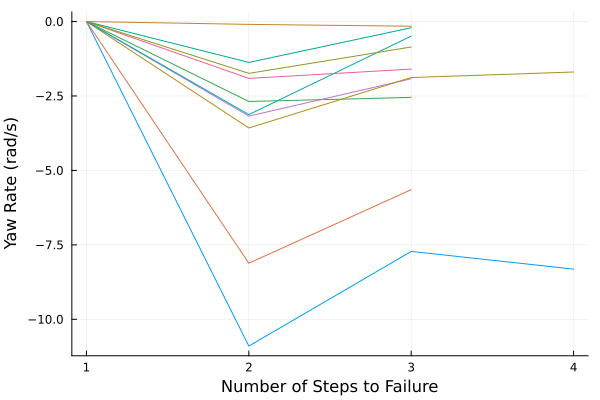

In [20]:
p = plot(legend=false)
for (result, r) in sol
    AdaStress.replay!(mdp, result)
    plot!(p, mdp.sim.log, xlabel="Number of Steps to Failure", ylabel="Yaw Rate (rad/s)")
    
end
p